In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import torch.nn as nn  # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim  # For all Optimization algorithms, SGD, Adam, etc.
import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import os
import pandas as pd
from skimage import io
from torch.utils.data import (
    Dataset,
    DataLoader,
)
# !pip install tqdm
import tqdm

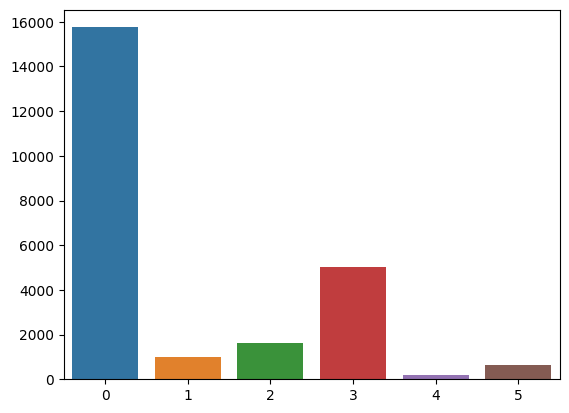

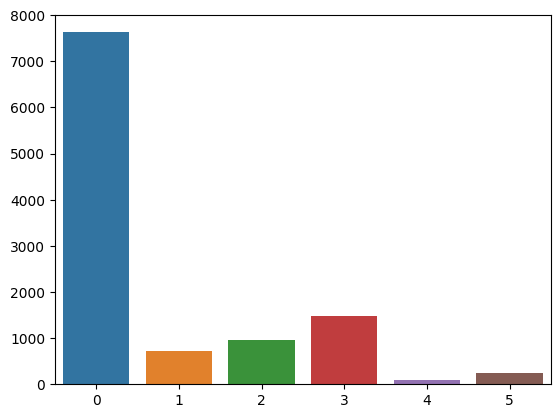

In [4]:
f = open('/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/train/train.json')
data_json = json.load(f)
data_df = pd.DataFrame.from_dict(data_json, orient='index').reset_index()
data_df.columns = ['path','label']
sns.barplot(x = list(data_df['label'].value_counts().index), y =data_df['label'].value_counts().values)
plt.show()

f = open('/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/test/test.json')
data_json = json.load(f)
data_df = pd.DataFrame.from_dict(data_json, orient='index').reset_index()
data_df.columns = ['path','label']
sns.barplot(x = list(data_df['label'].value_counts().index),y = data_df['label'].value_counts().values)
plt.show()

In [5]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

num_workers = 0
batch_size_train = 96
batch_size_test = 96
valid_size = 0.2

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256,256)),
    transforms.RandomCrop((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.3),
    ])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

class TIGDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        f = open(json_file)
        self.json_data = json.load(f)
        self.root_dir = root_dir
        self.transform = transform
        self.class_to_idx = {0:'good weld',1:'burn through',2:'contamination',3:'lack of fusion',4:'lack of shielding',5:'high travel speed'}

    def __len__(self):
        return len(self.json_data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, list(self.json_data.keys())[index])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.json_data[list(self.json_data.keys())[index]]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

train_dataset = TIGDataset(
    json_file='/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/train/train.json',
    root_dir='/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/train',
    transform=transform_train,
)

test_dataset = TIGDataset(
    json_file='/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/test/test.json',
    root_dir='/content/drive/MyDrive/ML-NN-COMMON FOLDER/TIG SS304/test',
    transform=transform_test,
)

num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_test,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test,
    num_workers=num_workers)



loaders = {'train': train_loader, 'valid': valid_loader, 'test': test_loader}

In [6]:
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

202
51
117


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


tensor([2, 1, 0, 2, 2, 2, 0, 0, 0, 2, 2, 3, 0, 0, 3, 0, 1, 0, 0, 0, 0, 0, 0, 2,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
        3, 3, 0, 3, 0, 0, 3, 0, 0, 0, 2, 0, 3, 3, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 3, 0, 3, 0, 0, 0, 0, 3, 0, 1, 2, 0, 5, 2, 0, 2, 0, 3, 0, 0, 0, 0, 0])

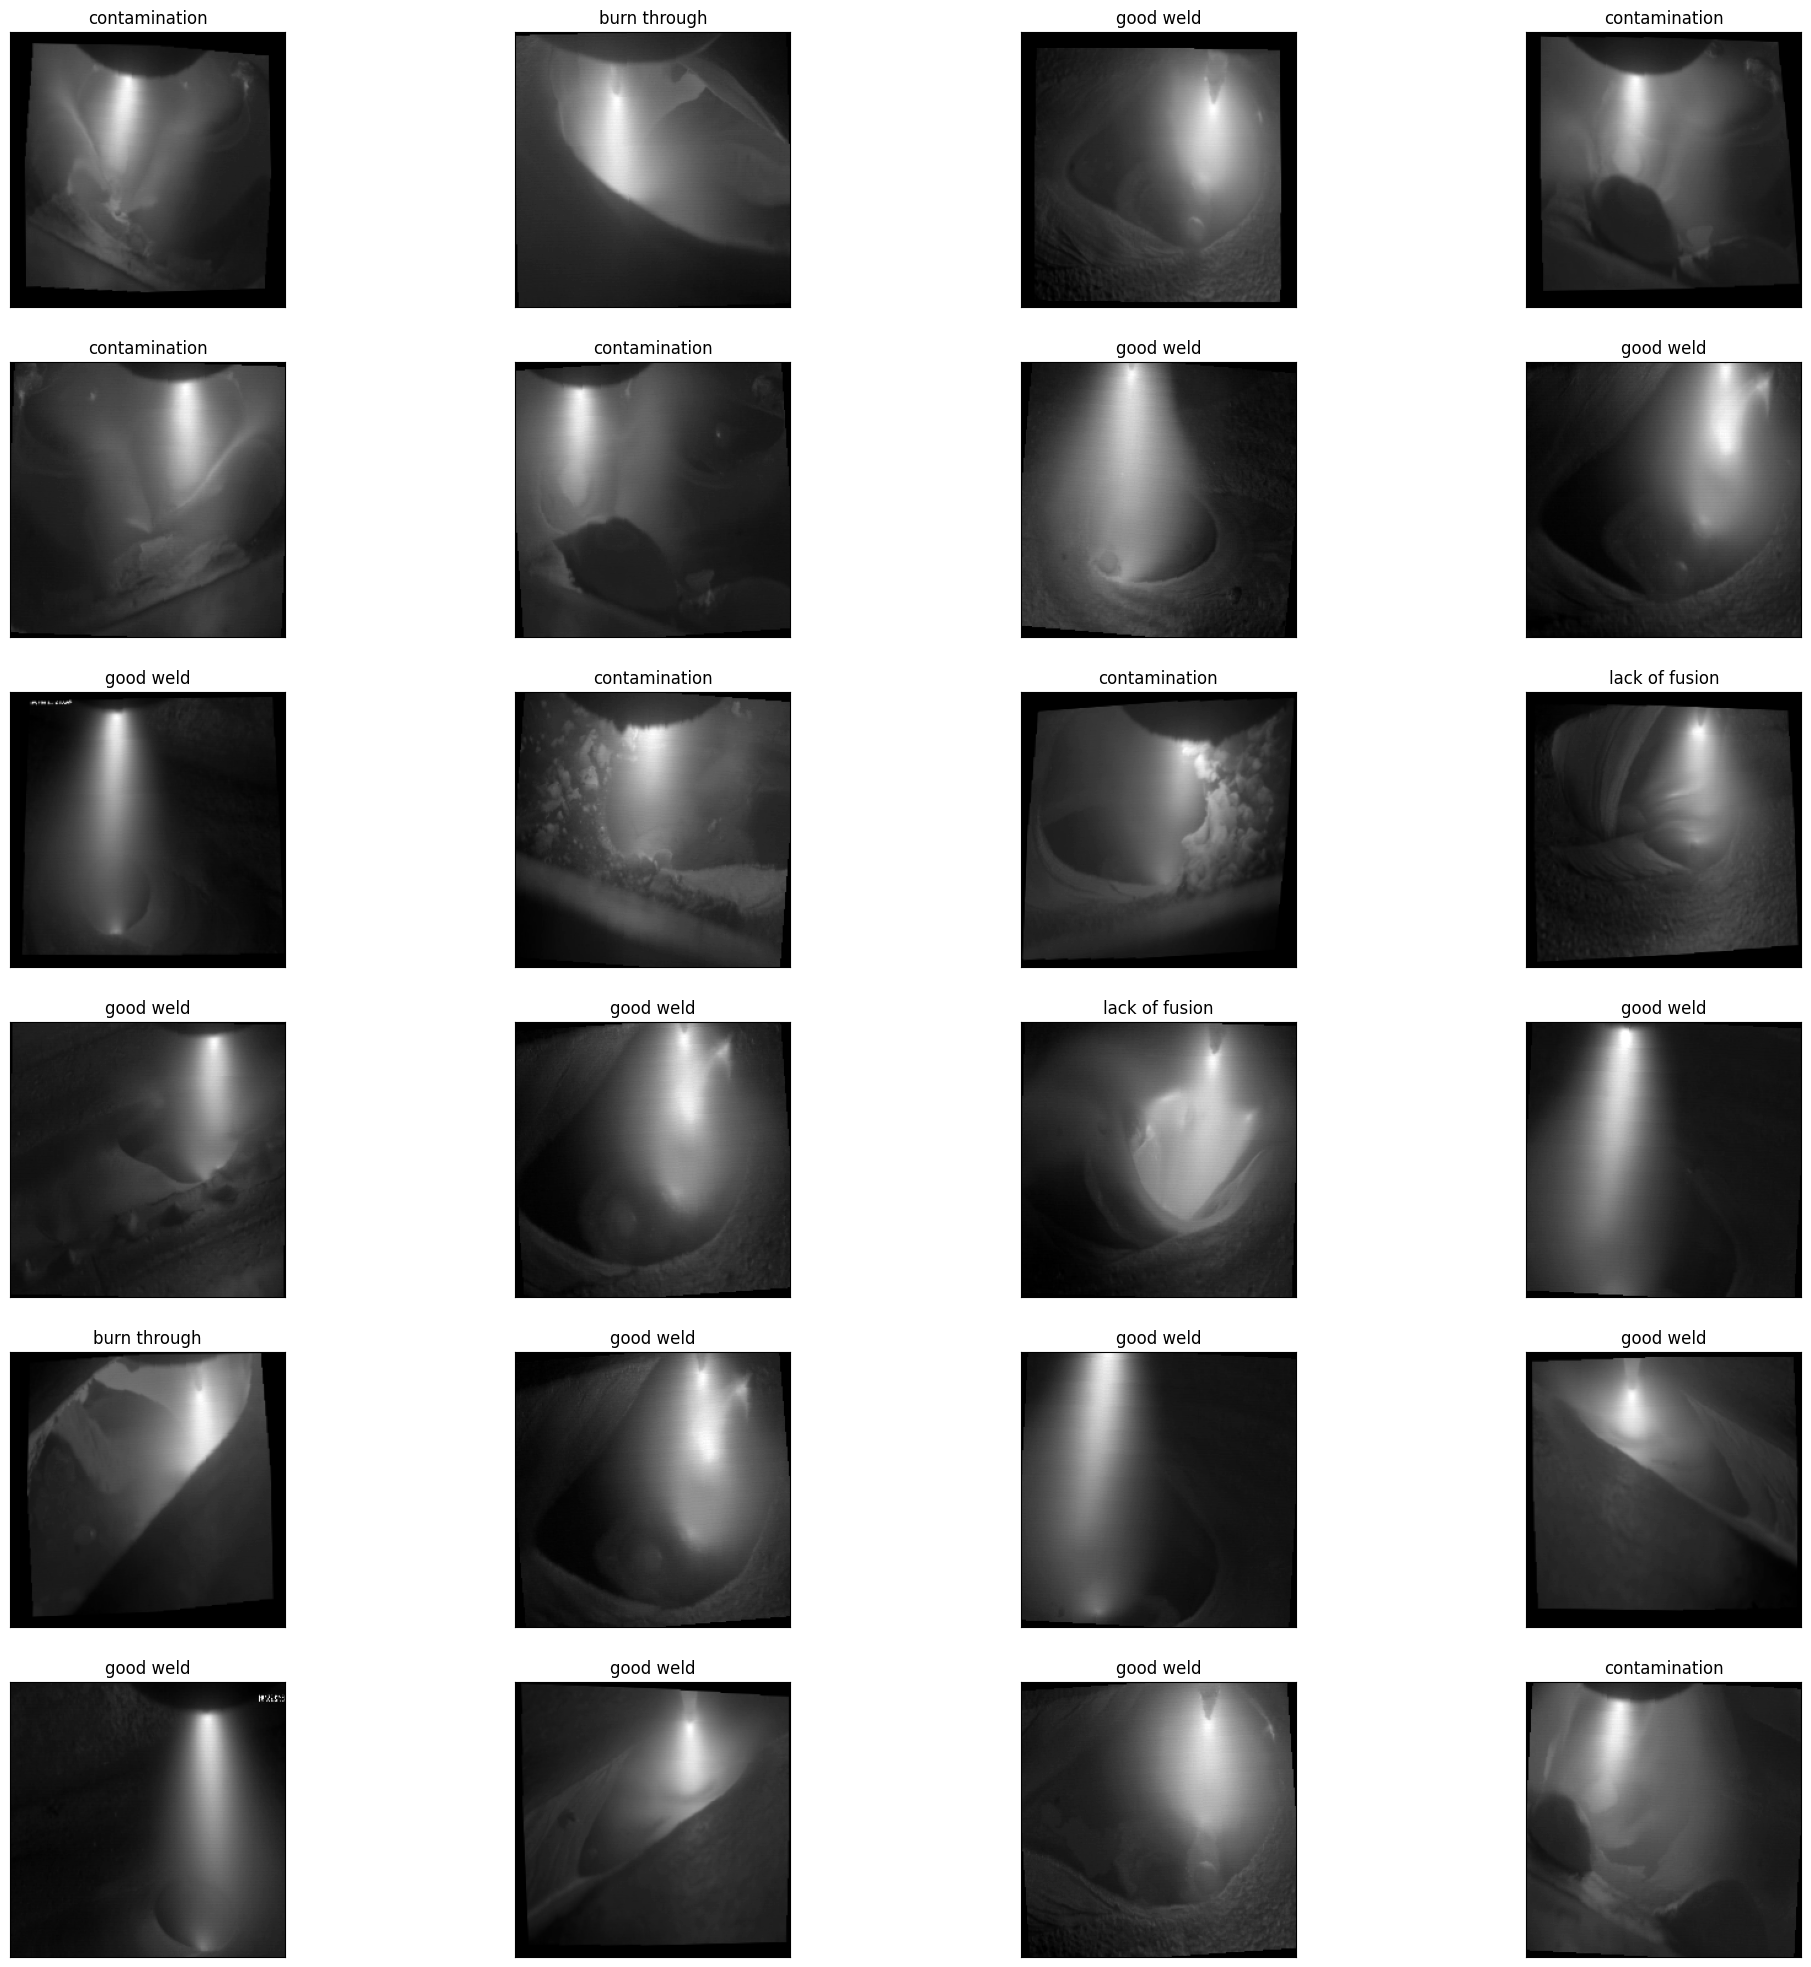

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline


## TODO: visualize a batch of the train data loader
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)), cmap='gray')

# obtain one batch of training images
#dataiter = iter(train_loader)
images, labels = next(iter(train_loader))
images = images.numpy() # convert images to numpy for display

classes = train_dataset.class_to_idx

# print(labels)
# train_data.classes
fig = plt.figure(figsize=(25, 25))
## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)
for idx in np.arange(24):
    ax = fig.add_subplot(6,4, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels.numpy()[idx]])
labels

In [8]:
criterion_transfer = nn.CrossEntropyLoss()

# def get_optimizer_transfer(model):
#     ## TODO: select and return an optimizer
#     optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
#     return optimizer

def get_optimizer_transfer(model):
    ## TODO: select and return an optimizer
    optimizer = optim.SGD(model.classifier.parameters(), lr=0.014)
    return optimizer

In [9]:
from torchvision import datasets, models, transforms
vgg16 = models.vgg16(pretrained=True)

for param in vgg16.features.parameters():
    param.requires_grad = False

use_cuda = torch.cuda.is_available()

n_classes = 6
n_inputs = vgg16.classifier[6].in_features
# n_inputs will be 4096 for this case

# vgg16.classifier[6] = nn.Sequential(
#     nn.Linear(n_inputs, 256),
#     nn.ReLU(),
#     nn.Dropout(0.4),
#     nn.Linear(256, n_classes)
# #     ,nn.Softmax(dim=1)
# )

vgg16.classifier[6] = nn.Linear(n_inputs, n_classes)

model_transfer = vgg16

if use_cuda:
    model_transfer = model_transfer.cuda()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 76.7MB/s]


In [10]:
!pip install torchsummary
from torchsummary import summary
summary(model_transfer, (3,244,244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 244, 244]           1,792
              ReLU-2         [-1, 64, 244, 244]               0
            Conv2d-3         [-1, 64, 244, 244]          36,928
              ReLU-4         [-1, 64, 244, 244]               0
         MaxPool2d-5         [-1, 64, 122, 122]               0
            Conv2d-6        [-1, 128, 122, 122]          73,856
              ReLU-7        [-1, 128, 122, 122]               0
            Conv2d-8        [-1, 128, 122, 122]         147,584
              ReLU-9        [-1, 128, 122, 122]               0
        MaxPool2d-10          [-1, 128, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]         295,168
             ReLU-12          [-1, 256, 61, 61]               0
           Conv2d-13          [-1, 256, 61, 61]         590,080
             ReLU-14          [-1, 256,

In [11]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    train_losses = {}
    valid_losses = {}

    for epoch in range(1, n_epochs+1):
        train_loss_list = []
        valid_loss_list = []

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        print(f'Epoch: {epoch}')

        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        print('Training set:')
        for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['train'])):
#             print(batch_idx)
            # move to GPU
            data = data.expand(data.size()[0], 3, *data.size()[2:])
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            train_loss_list.append(loss.data.item())


        ######################
        # validate the model #
        ######################
        # set the model to evaluation mode
        print('Validation set:')
        model.eval()
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['valid'])):
                # move to GPU
                data = data.expand(data.size()[0], 3, *data.size()[2:])
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## TODO: update average validation loss

                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss
                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))

                valid_loss_list.append(loss.data.item())


        # print training/validation statistics
        train_losses[epoch] = train_loss_list
        valid_losses[epoch] = valid_loss_list
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch,
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model, train_losses, valid_losses

In [12]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    losses = []
    pred_label = []
    true_label = []
    correct = 0.
    total = 0.
    print('Test set')
    # set the module to evaluation mode
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(tqdm.notebook.tqdm(loaders['test'])):
            # move to GPU
            data = data.expand(data.size()[0], 3, *data.size()[2:])
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            losses.append(loss.data.item())
            # update average test loss
            test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
            # convert output probabilities to predicted class
#             _,pred = output.data.max(1, keepdim=True)[1]
            _,pred = torch.max(output, 1) ## fetching the indices of max values

            pred_label.extend(pred.cpu().numpy().reshape(-1,))
            true_label.extend(target.cpu().numpy().reshape(-1,))
            # compare predictions to true label
            correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return losses, true_label, pred_label

In [13]:
n_epochs = 1
_, train_losses, valid_losses = train(n_epochs, loaders, model_transfer, get_optimizer_transfer(model_transfer),
                      criterion_transfer, use_cuda, 'model_transfer6.pt')

model_transfer.load_state_dict(torch.load('model_transfer6.pt'))

losses, true_label, pred_label  = test(loaders, model_transfer, criterion_transfer, use_cuda)

%cd /kaggle/working
from IPython.display import FileLink
FileLink(r'model_transfer6.pt')

Epoch: 1
Training set:


  0%|          | 0/202 [00:00<?, ?it/s]

Validation set:


  0%|          | 0/51 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.402244 	Validation Loss: 0.121506
Validation loss decreased (inf --> 0.121506).  Saving model ...
Test set


  0%|          | 0/117 [00:00<?, ?it/s]

Test Loss: 0.177723


Test Accuracy: 93% (10478/11160)
[Errno 2] No such file or directory: '/kaggle/working'
/content


/content/model_transfer6.pt

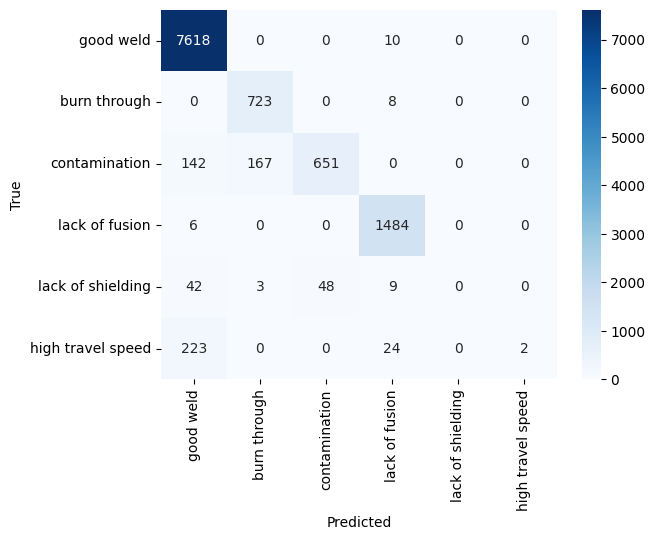

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      7628
           1       0.81      0.99      0.89       731
           2       0.93      0.68      0.78       960
           3       0.97      1.00      0.98      1490
           4       0.00      0.00      0.00       102
           5       1.00      0.01      0.02       249

    accuracy                           0.94     11160
   macro avg       0.78      0.61      0.61     11160
weighted avg       0.93      0.94      0.92     11160



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
from sklearn.metrics import confusion_matrix
c_matrix = confusion_matrix(true_label, pred_label)
ax = sns.heatmap(c_matrix, annot=True,fmt='', cmap='Blues',
                 xticklabels = test_dataset.class_to_idx.values(), yticklabels = test_dataset.class_to_idx.values())
ax.set(xlabel='Predicted', ylabel='True')
plt.show()

from sklearn.metrics import classification_report
print(classification_report(true_label, pred_label))